In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import pickle

In [2]:
import os

In [16]:
path = os.getcwd()
df = pd.read_csv(path+"/data/train.csv")
stores = pd.read_csv(path+"/data/stores.csv")
test = pd.read_csv(path+"/data/test.csv")
oil = pd.read_csv(path+"/data/oil.csv")
transactions = pd.read_csv(path+"/data/transactions.csv")
holidays = pd.read_csv(path+"/data/holidays_events.csv")
df.date = pd.to_datetime(df.date)
oil.date = pd.to_datetime(oil.date)
transactions.date = pd.to_datetime(transactions.date)
holidays.date = pd.to_datetime(holidays.date)
df.drop(columns='id', inplace=True)

In [164]:
print(df.head())
print(oil.head())
print(transactions.head())
print(holidays.head())
print(test.head())

        date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0          0.0
1 2013-01-01          1   BABY CARE    0.0          0.0
2 2013-01-01          1      BEAUTY    0.0          0.0
3 2013-01-01          1   BEVERAGES    0.0          0.0
4 2013-01-01          1       BOOKS    0.0          0.0
        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
date
2013-01-01     770.000000
2013-01-02    2026.413043
2013-01-03    1706.608696
2013-01-04    1706.391304
2013-01-05    2034.195652
Name: transactions, dtype: float64
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local 

In [206]:
print(df.describe())
print(df.info())
print(f'The start datetime of the training dat is: {df.date.min()}')
print(f'The end datetime of the training dat is: {df.date.max()}')
print('Testing:')
print(test.describe())

          store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.750000e+01  3.577757e+02  3.460289e+01
std    1.558579e+01  1.101998e+03  9.948216e+01
min    1.000000e+00  0.000000e+00  0.000000e+00
25%    1.400000e+01  0.000000e+00  0.000000e+00
50%    2.750000e+01  1.100000e+01  1.000000e+00
75%    4.100000e+01  1.958473e+02  1.600000e+01
max    5.400000e+01  1.247170e+05  1.006000e+03
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    int64         
 2   family       object        
 3   sales        float64       
 4   onpromotion  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 114.5+ MB
None
The start datetime of the training dat is: 2013-01-01 00:00:00
The end datetime of the training dat is: 2017-08-15 00:00:00
Testing:
    

In [10]:
stores.store_nbr.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54])

In [9]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [5]:
start = pd.Timestamp(2015,1,1,0)
end = pd.Timestamp(2016,1,1,0)

## Removing missing data

There is no missing data in the train dat set.

In [6]:
df.isnull().any(axis = 1).any()

False

# Exploratory feature analysis

## Feature Corelation

In [46]:
df_oh = pd.get_dummies(df, prefix='', prefix_sep='')
df_oh['store_nbr'] = df_oh[['store_nbr']].astype(str)
df_oh = pd.get_dummies(df_oh)

In [6]:
corrs = df_oh.corr()

In [10]:
corrs = corrs[['sales']].sort_values(by='sales', ascending = False)

In [40]:
print(corrs[(~ corrs.index.str.startswith('store_nbr')) & (corrs['sales']>0.1)])
print(corrs[corrs.index.str.startswith('store_nbr')].sort_values(by='sales',ascending = False).iloc[:5,:])

                sales
sales        1.000000
onpromotion  0.755648
GROCERY I    0.548490
BEVERAGES    0.325324
PRODUCE      0.159064
CLEANING     0.114639
                 sales
store_nbr_44  0.094666
store_nbr_45  0.077642
store_nbr_47  0.069680
store_nbr_3   0.068634
store_nbr_49  0.052795


In [65]:
# total sales per day per store
sales_ps = df.groupby(['date','store_nbr'])['sales','onpromotion'].sum()
sales_ps = sales_ps.groupby(['date'])['sales','onpromotion'].mean()
sales_ps.head()

,sales,onpromotion
date,,
2013-01-01,46.511463,0.0
2013-01-02,9186.896629,0.0
2013-01-03,6693.726502,0.0
2013-01-04,6564.068094,0.0
2013-01-05,8839.817060,0.0


In [83]:
corr_oil = pd.merge(oil, sales_ps, how = 'right', on='date').interpolate(method='bfill')

<AxesSubplot:xlabel='date'>

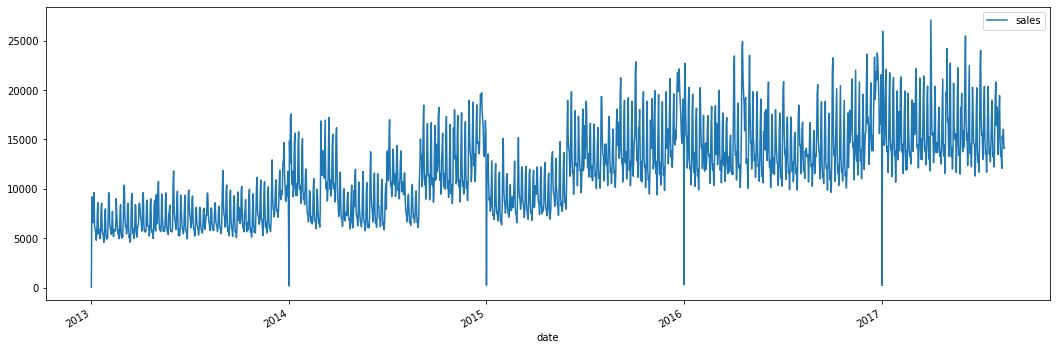

In [78]:
corr_oil.plot(x = 'date', y=['sales'], figsize=(18,6))

In [84]:
corr_oil['oil_bin'] = pd.cut(corr_oil['dcoilwtico'],2,include_lowest =True)

In [98]:
corr_oil.head()

,date,dcoilwtico,sales,onpromotion,oil_bin
0,2013-01-01,93.14,46.511463,0.0,"(68.405, 110.62]"
1,2013-01-02,93.14,9186.896629,0.0,"(68.405, 110.62]"
2,2013-01-03,92.97,6693.726502,0.0,"(68.405, 110.62]"
3,2013-01-04,93.12,6564.068094,0.0,"(68.405, 110.62]"
4,2013-01-05,93.20,8839.817060,0.0,"(68.405, 110.62]"


<AxesSubplot:xlabel='dcoilwtico', ylabel='sales'>

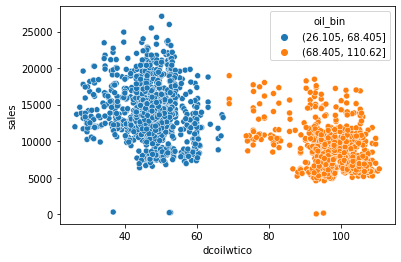

In [87]:
sns.scatterplot(data=corr_oil,x = 'dcoilwtico', y='sales', hue = 'oil_bin')

In [88]:
transactions = transactions.groupby('date')['transactions'].mean()

## Explore the impact of the promotions on the product sales

Before going into all the details of seasonality and trends and lags, and adding all the time series features, let's take a look at how other features influence the product sales.

First I want to know what is the trend of sales numbers in each product category and compare it with the promotions.

In [5]:
promo_allT = pd.DataFrame(df.groupby(['family'])['onpromotion'].sum())

In [6]:
promo_allT = promo_allT.reset_index()

In [7]:
sales_allT = pd.DataFrame(df.groupby(['family'])['sales'].sum())

In [8]:
sales_allT = sales_allT.reset_index()

In [9]:
df_allT = pd.merge(promo_allT, sales_allT, how = 'inner', on='family')

In [10]:
df_allT = df_allT.sort_values(by='onpromotion')
df_allT.head()

,family,onpromotion,sales
4,BOOKS,2772.0,6438.0
1,BABY CARE,5294.0,10051.0
17,HOME APPLIANCES,16975.0,41601.0
14,HARDWARE,53827.0,103470.0
31,SCHOOL AND OFFICE SUPPLIES,62415.0,269316.0


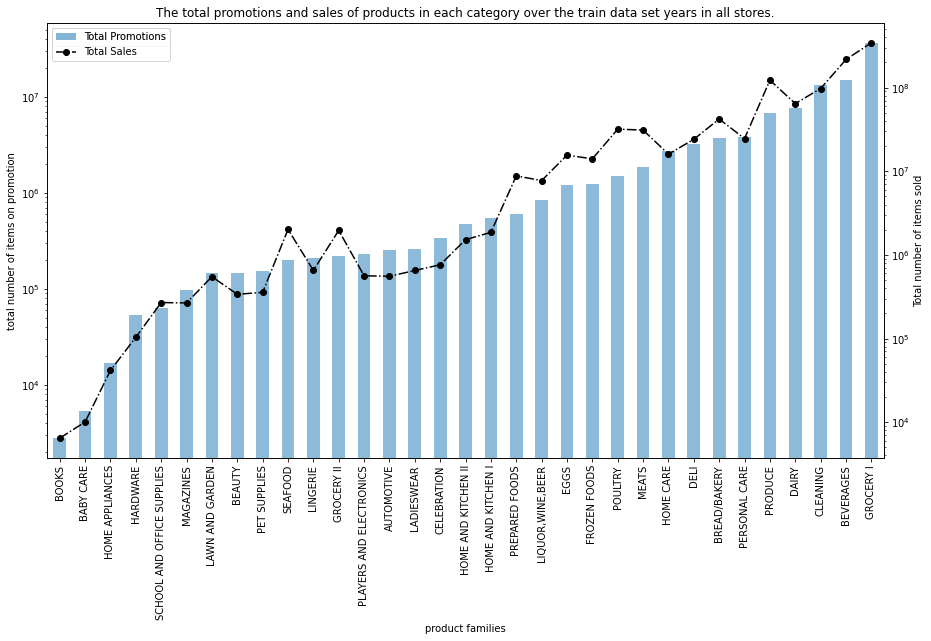

In [11]:
ax = df_allT.plot(kind='bar',figsize=(15,8),x='family',y='onpromotion', alpha = 0.5,label='Total Promotions')
ax.set_xlabel('product families')
ax.set_ylabel('total number of items on promotion')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(df_allT['family'],df_allT['sales'], marker='o',ls='-.',c='k',label='Total Sales')
ax2.set_ylabel('Total number of items sold')
ax2.set_yscale('log')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title("The total promotions and sales of products in each category over the train data set years in all stores.")
plt.show()

Seems like that the product categories with more promotions sell better. So does it mean that more promotions lead to more sales, or maybe those popular products naturally get more promotions and exposures?

In [12]:
df_pdist = pd.DataFrame(df.groupby(['date','family'])['onpromotion'].sum()).reset_index()
df_sdist = pd.DataFrame(df.groupby(['date','family'])['sales'].sum()).reset_index()

In [13]:
df_sdist.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-01,BABY CARE,0.0
2,2013-01-01,BEAUTY,2.0
3,2013-01-01,BEVERAGES,810.0
4,2013-01-01,BOOKS,0.0


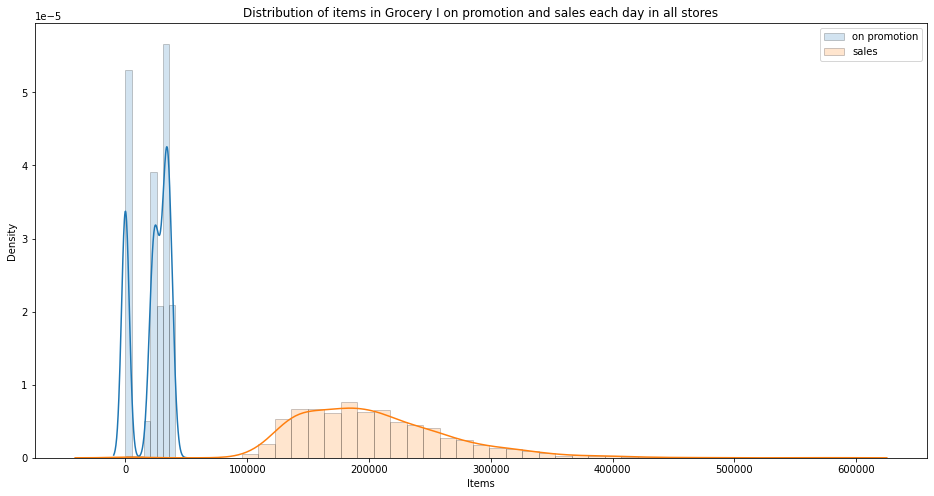

In [14]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))

sns.distplot(df_pdist[df['family'] == 'GROCERY I']['onpromotion'], label='on promotion', hist_kws = hist_kws)
sns.distplot(df_sdist[df['family'] == 'GROCERY I']['sales'], label='sales', hist_kws = hist_kws)
plt.legend()
plt.title('Distribution of items in Grocery I on promotion and sales each day in all stores')
plt.xlabel('Items');


In [15]:
max5_sold_families = list(df_allT.iloc[-5:,0])
min10_sold_families = list(df_allT.iloc[0:11,0])
eleven2twenty8 = list(df_allT.iloc[11:29,0])

In [ ]:
max5_sold_families

In [ ]:
min10_sold_families

Text(0.5, 0, 'Items')

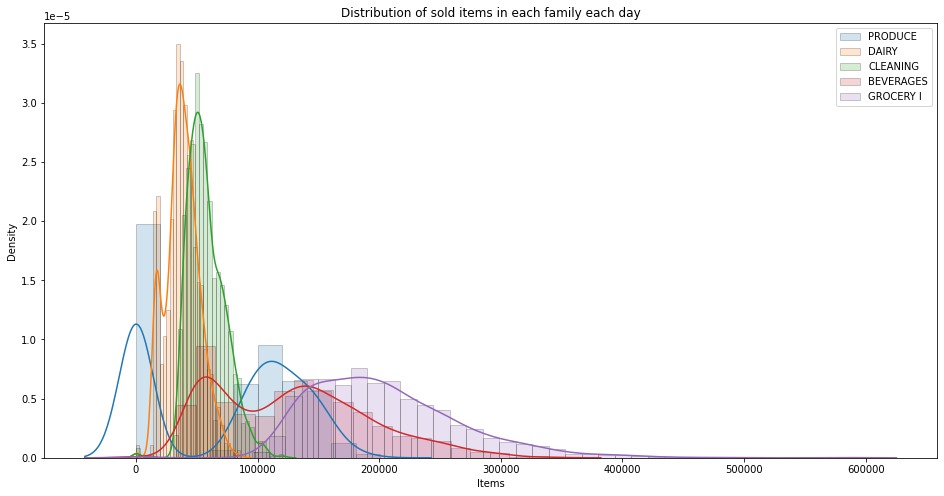

In [16]:
hist_kws = {'histtype':'bar', 'edgecolor':'black', 'alpha': 0.2}

plt.figure(figsize=(16,8))
for family in max5_sold_families:
    sns.distplot(df_sdist[df['family'] == family]['sales'], label=family, hist_kws = hist_kws)

plt.legend()
plt.title('Distribution of sold items in each family each day')
plt.xlabel('Items')
#plt.xscale('log')

In [ ]:
# df2 = df.copy()
# df2['onpromotion'] = pd.cut(df2['onpromotion'],[0.0,100,200,300,400,500,600,700,800,900,1006.0],include_lowest =True)

In [ ]:
df.head()

In [17]:
mean_sales = pd.DataFrame(df.groupby(['family','onpromotion'])['sales'].mean()).reset_index()

In [18]:
mean_sales.head()

,family,onpromotion,sales
0,AUTOMOTIVE,0.0,3.815307
1,AUTOMOTIVE,1.0,1.430927
2,AUTOMOTIVE,2.0,2.983124
3,AUTOMOTIVE,3.0,4.572786
4,AUTOMOTIVE,4.0,6.274716


From the plots below, we can see that there exists some quadratic input-output relationshoip between promotions and sales. But for each product family, the coefficients differ. So if I would like to do some feature transformation to include this information, at least in linear models, only adding quadratic terms of promotions is not enough. I also need to add interactive features of promotions and product category feature. But How? Maybe not linear model... Maybe binning the promotion feature is a more practical and better approach...

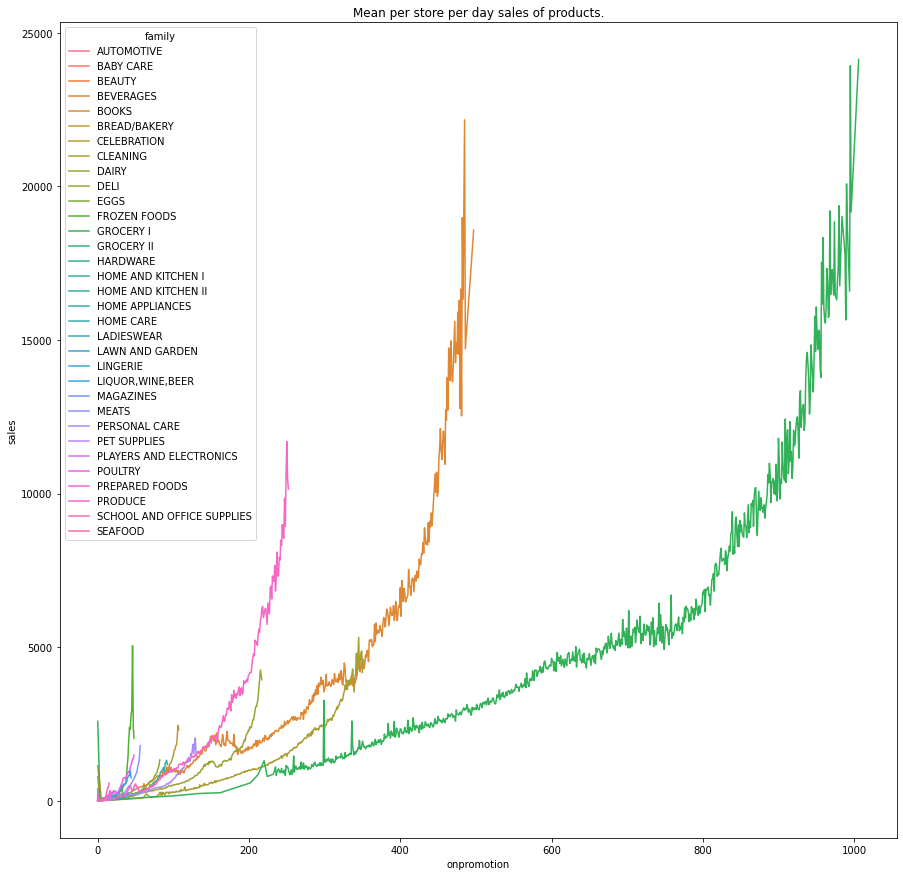

In [19]:
fig,ax = plt.subplots(figsize=(15,15))
sns.lineplot(data=mean_sales, x="onpromotion", y="sales", hue="family")
plt.title('Mean per store per day sales of products.')
plt.show()

In [138]:
# fig,ax = plt.subplots(figsize=(13,8))
# for family in min10_sold_families:
#     sns.lineplot(data=mean_sales[mean_sales['family']==family], x="onpromotion", y="sales",label=family)
# plt.legend()
# plt.show()


In [139]:
# fig,ax = plt.subplots(figsize=(15,10))
# for family in eleven2twenty8:
#     sns.lineplot(data=mean_sales[mean_sales['family']==family], x="onpromotion", y="sales",label = family)
# plt.legend()
# plt.show()

## let me see whether there is lagged response of promotions on sales

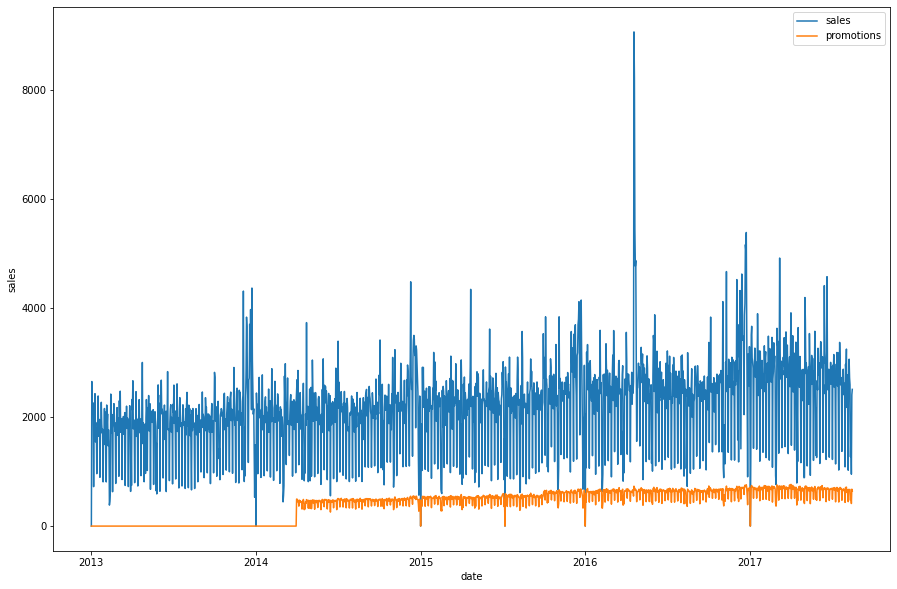

In [22]:
fig,ax = plt.subplots(figsize=(15,10))
sns.lineplot(data=df[(df['family']=='GROCERY I') & (df['store_nbr']==1)], x="date", y="sales", label = 'sales')
sns.lineplot(data=df[(df['family']=='GROCERY I') & (df['store_nbr']==1)], x="date", y="onpromotion", label = 'promotions')
plt.legend()

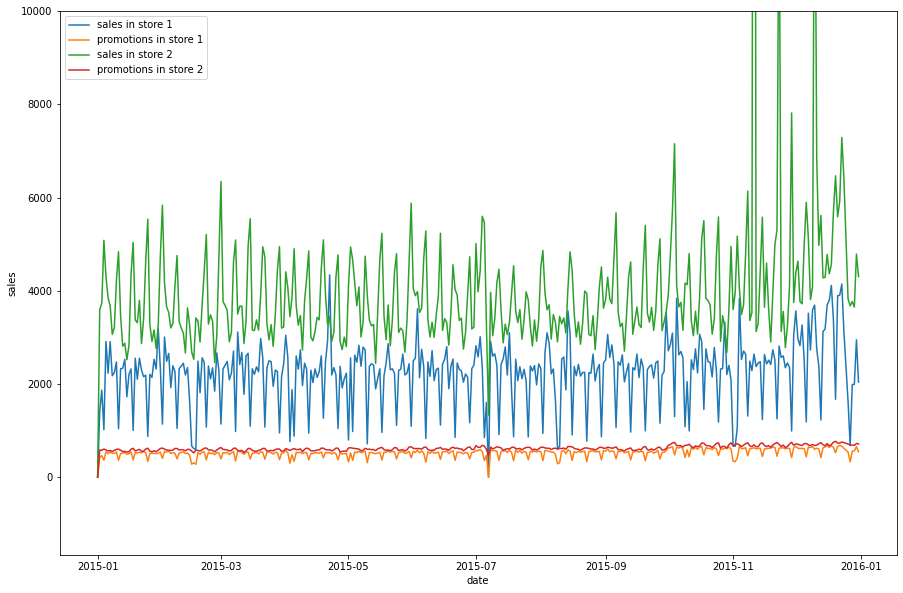

In [23]:
fig,ax = plt.subplots(figsize=(15,10))
subdf = df[(df['family']=='GROCERY I') & (df['store_nbr']==1) & (df['date']>=start) & (df['date']<end)]
subdf2 = df[(df['family']=='GROCERY I') & (df['store_nbr']==2) & (df['date']>=start) & (df['date']<end)]
sns.lineplot(data=subdf, x="date", y="sales", label = 'sales in store 1')
sns.lineplot(data=subdf, x="date", y="onpromotion", label = 'promotions in store 1')
sns.lineplot(data=subdf2, x="date", y="sales", label = 'sales in store 2')
sns.lineplot(data=subdf2, x="date", y="onpromotion", label = 'promotions in store 2')
plt.legend()
ax.set_ylim(ymax=10000)
plt.show()

In [ ]:
test.head()

# Creating features for linear regression

Things I need to do:
* Binning onpromotion
* Turn Store_nbr into string 
* One-hot Encoding
* Trend Term : Linear
* Seasonlality terms : Fourier Features; Make seasonal plots and periodograms to see the frequency
* Serial Dependence Term (Lag terms)

To start with, I will first focusing on GROCERY I, assuming trend and seasonality for all family categories are the same

In [100]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram

In [7]:
#train = train[train['date']< end]

In [142]:
train = corr_oil
train = train.set_index("date").to_period("D")

In [143]:
train['onpromotion']=pd.cut(train['onpromotion'],5,include_lowest =True)

In [11]:
#df['store_nbr'] = df[['store_nbr']].astype(str)

In [144]:
train = pd.get_dummies(train)

In [146]:
train = train.drop(columns='dcoilwtico')

In [147]:
print(train.shape)
print(train.dtypes)

(1684, 8)
sales                               float64
onpromotion_(-2.19, 437.756]          uint8
onpromotion_(437.756, 875.511]        uint8
onpromotion_(875.511, 1313.267]       uint8
onpromotion_(1313.267, 1751.022]      uint8
onpromotion_(1751.022, 2188.778]      uint8
oil_bin_(26.105, 68.405]              uint8
oil_bin_(68.405, 110.62]              uint8
dtype: object


In [106]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(10,8))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

## Seasonal features

In [23]:
# df_temp = pd.read_csv(path+"/data/train.csv")
# df_temp['date'] = pd.to_datetime(df_temp['date'])

# df_temp = df_temp[(df_temp['store_nbr']==1) & (df_temp['family']=='GROCERY I') & (df_temp['date']<end)] 
# df_temp = df_temp.set_index("date").to_period('D')

In [21]:
# df_temp2 = pd.read_csv(path+"/data/train.csv")
# df_temp2['date'] = pd.to_datetime(df_temp2['date'])

# df_temp2 = df_temp2[(df_temp2['store_nbr']==1) & (df_temp2['family']=='LINGERIE') & (df_temp2['date']<end)] 
# df_temp2 = df_temp2.set_index("date").to_period('D')

In [24]:
# df_temp = df_temp.drop(columns=['id'])
# df_temp2 = df_temp2.drop(columns=['id'])

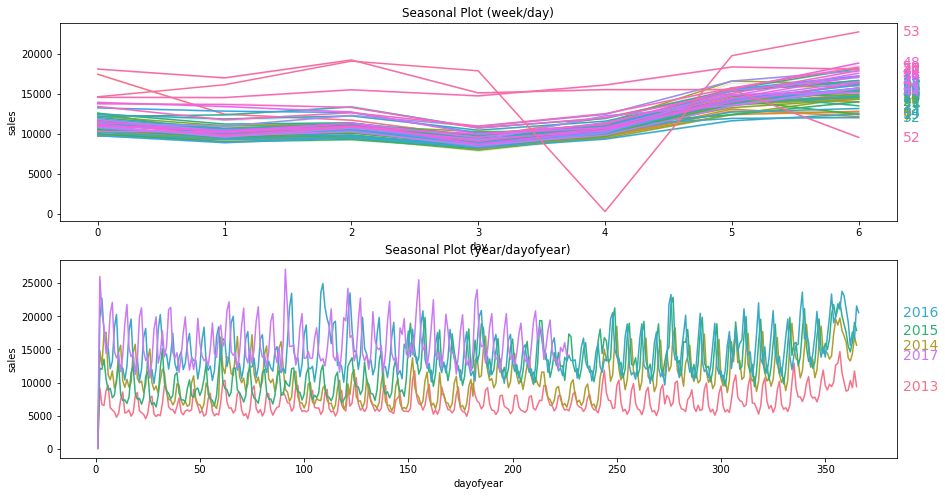

In [113]:
temp = train.copy()
temp["day"] = temp.index.dayofweek  # the x-axis (freq)
temp["week"] = temp.index.week  # the seasonal period (period)

# days within a year
temp["dayofyear"] = temp.index.dayofyear
temp["year"] = temp.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 8))
seasonal_plot(temp, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(temp, y="sales", period="year", freq="dayofyear", ax=ax1);

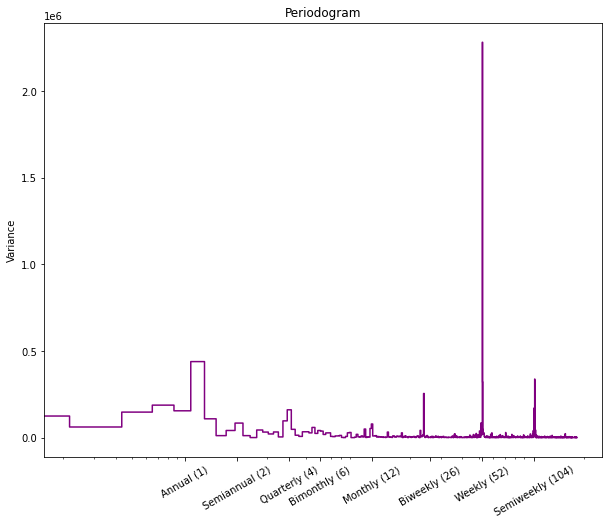

In [114]:
plot_periodogram(temp.sales);

In [148]:
fourier = CalendarFourier(freq="A", order=10)  # 4 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [149]:
X.head(5)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


In [150]:
train = pd.concat([train,X], axis = 1)

In [158]:
train_only_time = train.iloc[:,8:]

In [159]:
train_only_time.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


In [151]:
train.head()

,sales,"onpromotion_(-2.19, 437.756]","onpromotion_(437.756, 875.511]","onpromotion_(875.511, 1313.267]","onpromotion_(1313.267, 1751.022]","onpromotion_(1751.022, 2188.778]","oil_bin_(26.105, 68.405]","oil_bin_(68.405, 110.62]",const,trend,...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,46.511463,1,0,0,0,0,0,1,1.0,1.0,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,9186.896629,1,0,0,0,0,0,1,1.0,2.0,...,0.103102,0.994671,0.120208,0.992749,0.137279,0.990532,0.154309,0.988023,0.171293,0.985220
2013-01-03,6693.726502,1,0,0,0,0,0,1,1.0,3.0,...,0.205104,0.978740,0.238673,0.971100,0.271958,0.962309,0.304921,0.952378,0.337523,0.941317
2013-01-04,6564.068094,1,0,0,0,0,0,1,1.0,4.0,...,0.304921,0.952378,0.353676,0.935368,0.401488,0.915864,0.448229,0.893919,0.493776,0.869589
2013-01-05,8839.817060,1,0,0,0,0,0,1,1.0,5.0,...,0.401488,0.915864,0.463550,0.886071,0.523416,0.852078,0.580800,0.814046,0.635432,0.772157


In [152]:
train.shape

(1684, 36)

# Base Model - Linear Regression

In [176]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [24]:
# df_test = pd.read_csv(path+"/data/train.csv")
# df_test.date = pd.to_datetime(df_test.date)
# df_test = df_test[df_test['date']>=pd.Timestamp(2017,1,1,0)]

# df_test = df_test.set_index("date").to_period("D")
# df_test = df_test.drop(columns=['id'])

# df_test['onpromotion']=pd.cut(df_test['onpromotion'],5,include_lowest =True)
# df_test['store_nbr'] = df_test[['store_nbr']].astype(str)

# df_test = pd.get_dummies(df_test)

# fourier = CalendarFourier(freq="A", order=12) 

# dp = DeterministicProcess(
#     index=df_test.index,
#     constant=True,              
#     order=1,                     
#     seasonal=True,               
#     additional_terms=[fourier], 
#     drop=True,                   
# )

# X = dp.in_sample()  
# df_test = pd.concat([df_test,X], axis = 1)

In [154]:
X = train.iloc[:,1:]
y = train.iloc[:,0]

base_model = LinearRegression(fit_intercept=False)
base_model.fit(X, y)

LinearRegression(fit_intercept=False)

In [160]:
X_time = train_only_time
time_model = LinearRegression(fit_intercept=False)
time_model.fit(X_time, y)

LinearRegression(fit_intercept=False)

In [161]:
y_pred = pd.Series(base_model.predict(X), index=y.index)
y_pred_t = pd.Series(time_model.predict(X_time), index=y.index)

In [134]:
y.head()

date
2013-01-01      46.511463
2013-01-02    9186.896629
2013-01-03    6693.726502
2013-01-04    6564.068094
2013-01-05    8839.817060
Freq: D, Name: sales, dtype: float64

In [156]:
print(f'The accuracy of base_model.score(X,y)')

0.7020875749503053

In [162]:
time_model.score(X_time,y)

0.5923644797021026

In [191]:
X_fore = dp.out_of_sample(steps=180)
#y_fore = pd.Series(base_model.predict(X_fore), index=X_fore.index)
y_fore_t = pd.Series(time_model.predict(X_fore), index=X_fore.index)

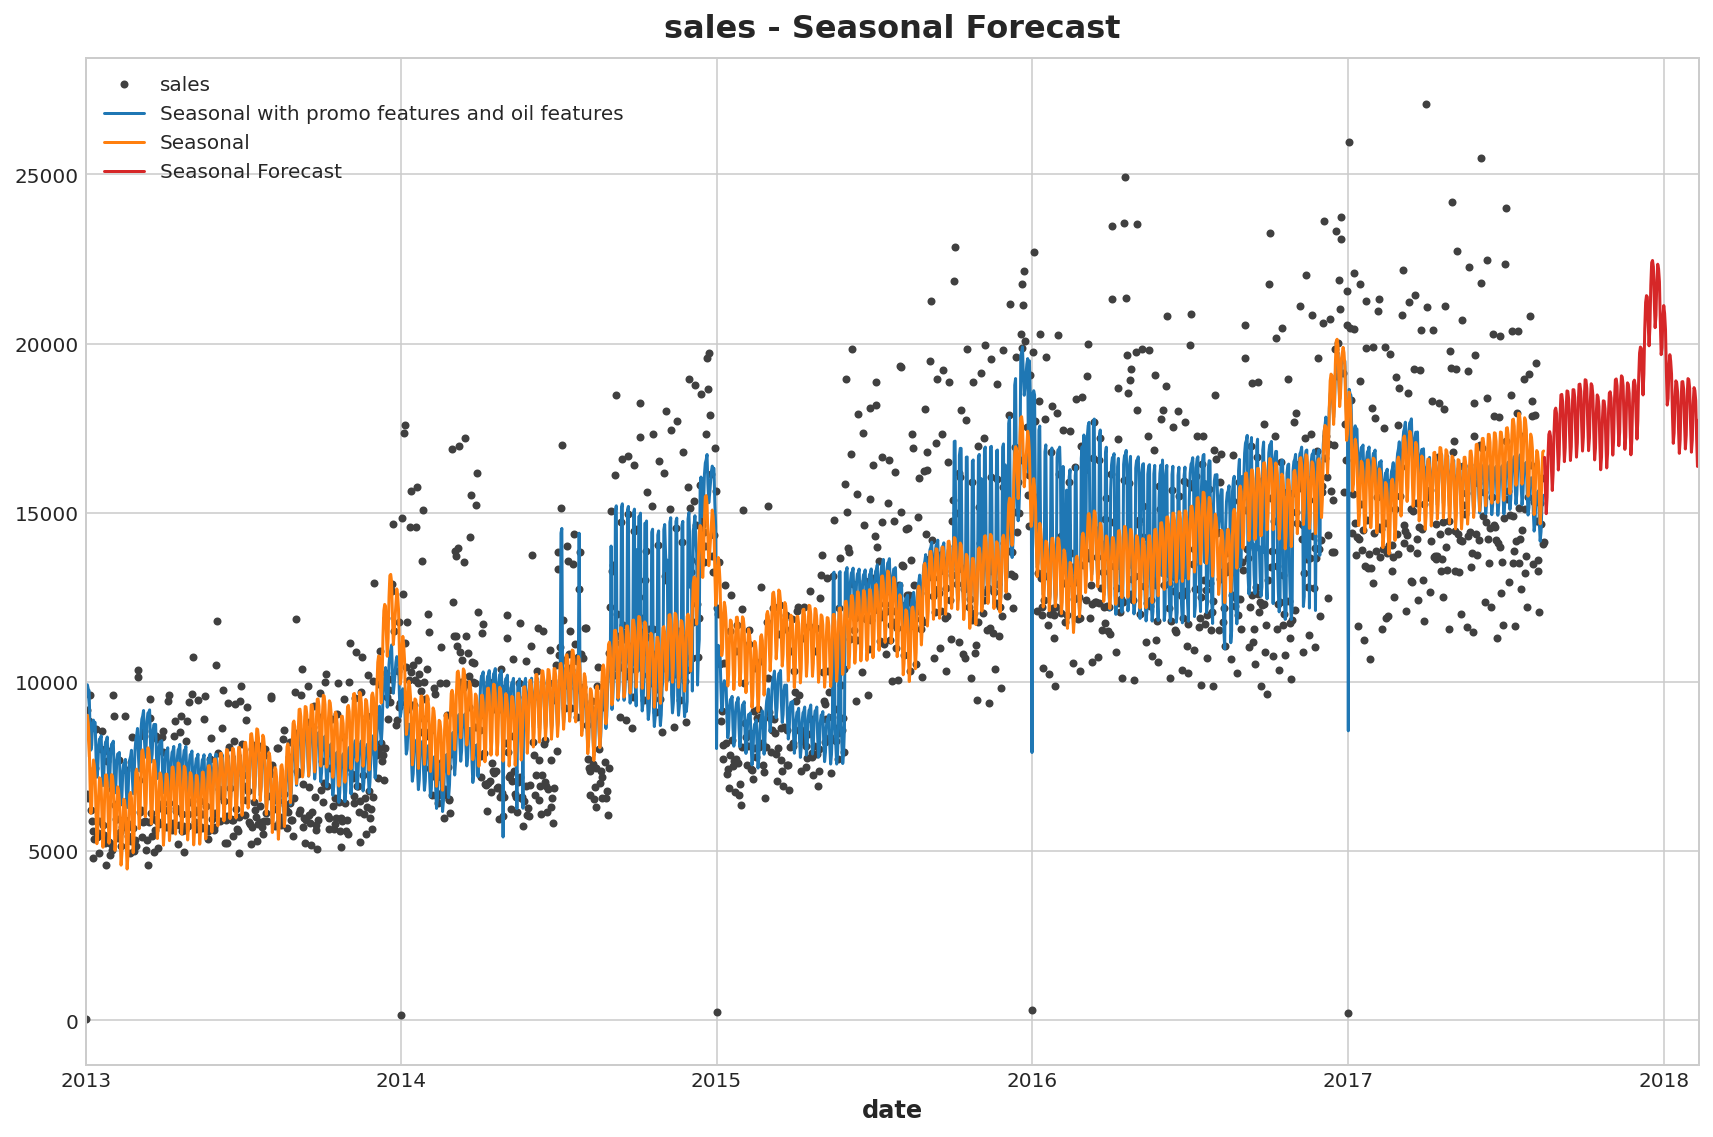

In [192]:
fig, ax = plt.subplots(figsize=(12,8))
ax = y.plot(color='0.25', style='.', title="sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal with promo features and oil features")
ax = y_pred_t.plot(ax=ax, label="Seasonal")
ax = y_fore_t.plot(ax=ax, label="Seasonal Forecast", color='C3')
#ax = y_fore.plot(ax=ax, label="Seasonal with features Forecast")
_ = ax.legend()

# Lag plots and time features

In [171]:
from statsmodels.graphics.tsaplots import plot_pacf


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

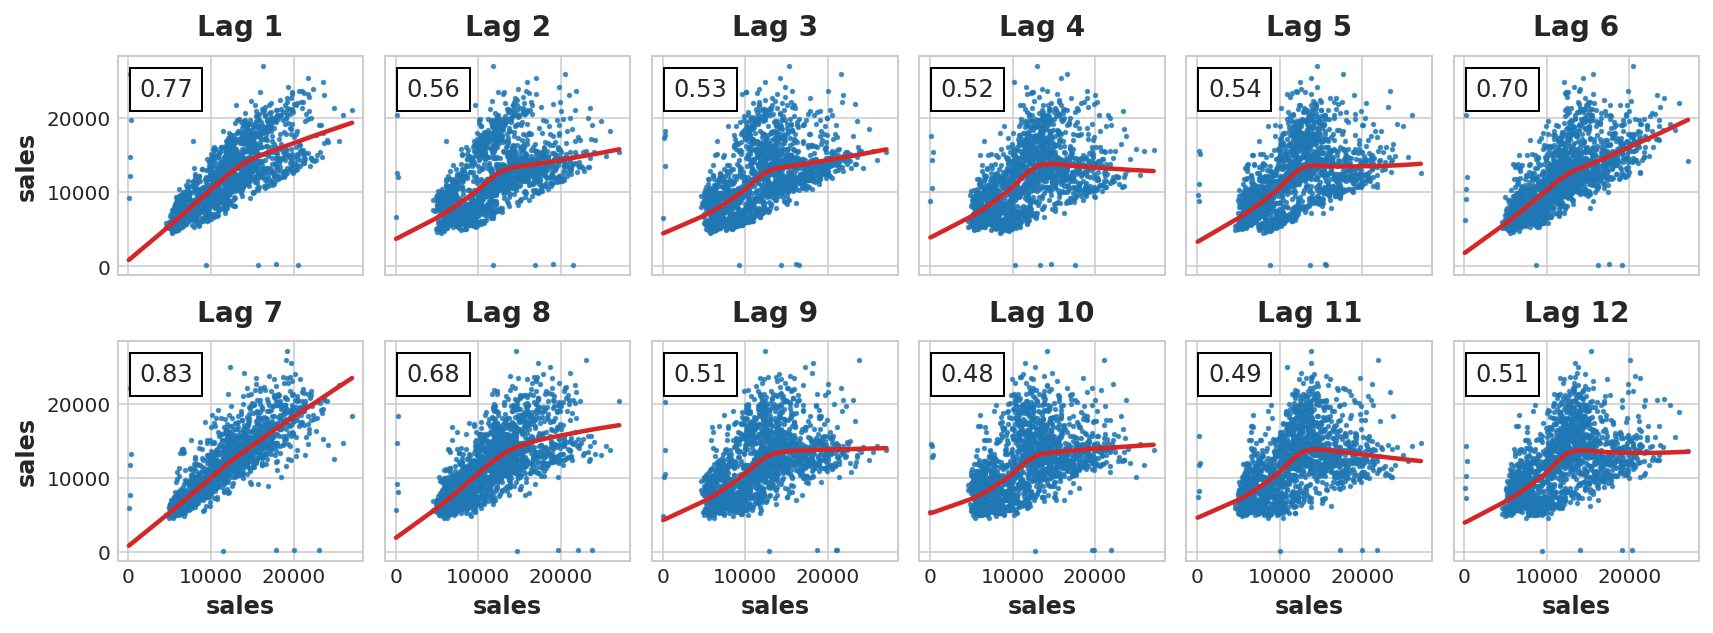

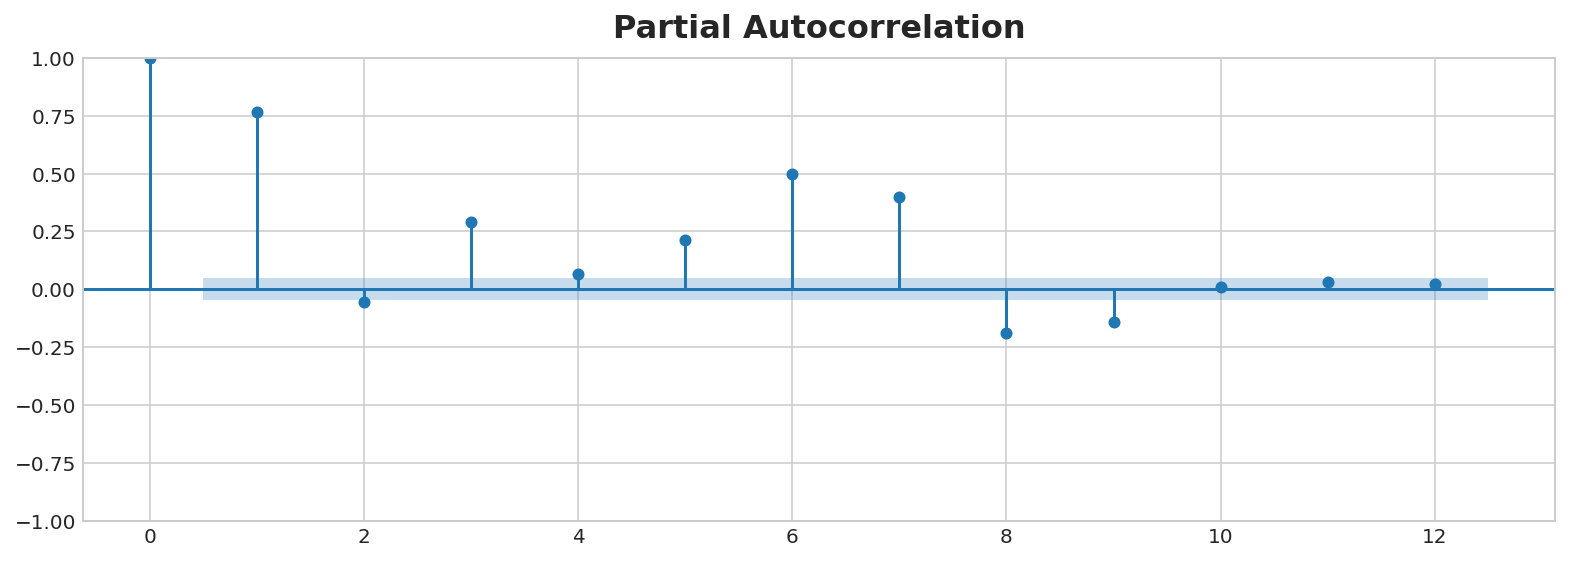

In [172]:
_ = plot_lags(train.sales, lags=12, nrows=2)
_ = plot_pacf(train.sales, lags=12)

In [174]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


lags = make_lags(train.sales, lags=9)
lags = lags.fillna(0.0)

In [175]:
lags.head()

,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9
date,,,,,,,,,
2013-01-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2013-01-02,46.511463,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2013-01-03,9186.896629,46.511463,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2013-01-04,6693.726502,9186.896629,46.511463,0.000000,0.0,0.0,0.0,0.0,0.0
2013-01-05,6564.068094,6693.726502,9186.896629,46.511463,0.0,0.0,0.0,0.0,0.0


In [178]:
train = pd.concat([train,lags], axis = 1)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 1:], train.iloc[:,0], test_size=60, shuffle=False)

In [182]:
lag_model = LinearRegression(fit_intercept=False)
lag_model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [183]:
lag_model.score(X_train,y_train)

0.8256336760726877

In [186]:
y_pred_lag_train = pd.Series(lag_model.predict(X_train), index=X_train.index)
y_pred_lag_test = pd.Series(lag_model.predict(X_test), index = X_test.index)

In [187]:
print(y_pred_lag_train.head())
print(y_pred_lag_test.head())

date
2013-01-01    5016.719050
2013-01-02    5108.235035
2013-01-03    8731.219437
2013-01-04    6633.955798
2013-01-05    7660.898715
Freq: D, dtype: float64
date
2017-06-17    18214.751220
2017-06-18    19690.218542
2017-06-19    14565.789292
2017-06-20    13921.177963
2017-06-21    15061.249816
Freq: D, dtype: float64


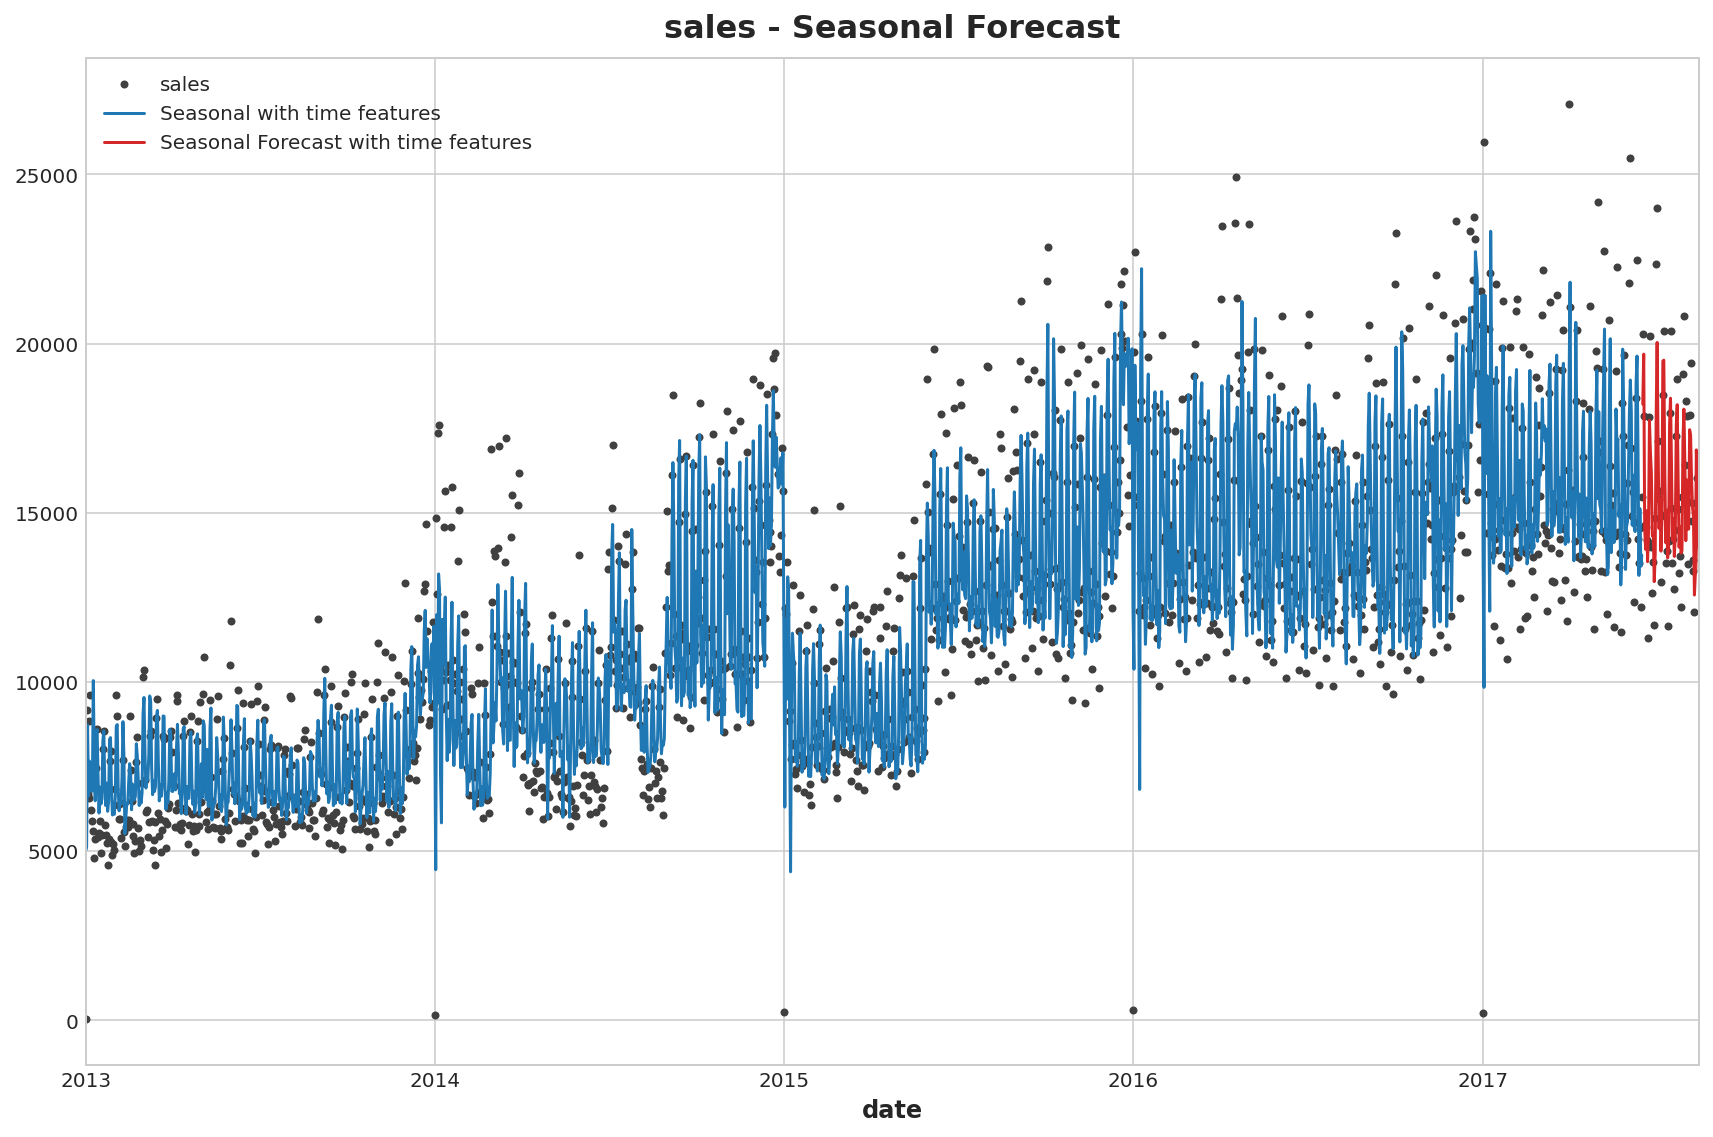

In [195]:
fig, ax = plt.subplots(figsize=(12,8))
ax = train.iloc[:,0].plot(color='0.25', style='.', title="sales - Seasonal Forecast")
ax = y_pred_lag_train.plot(ax=ax, label="Seasonal with time features")
ax = y_pred_lag_test.plot(ax=ax, label="Seasonal Forecast with time features", color='C3')
_ = ax.legend()

In [201]:
coefficients = pd.DataFrame(X_train.columns)
coefficients['coefs']=lag_model.coef_

In [204]:
coefficients = coefficients.sort_values(by='coefs',ascending=False)

In [205]:
print(coefficients)

                                   0         coefs
43                           y_lag_9  4.209889e+11
42                           y_lag_8  2.104944e+11
41                           y_lag_7  2.104944e+11
40                           y_lag_6  3.644786e+02
39                           y_lag_5  3.160699e+02
38                           y_lag_4  2.365342e+02
37                           y_lag_3  1.743635e+02
36                           y_lag_2  1.589790e+02
35                           y_lag_1  1.514777e+02
34                cos(10,freq=A-DEC)  1.261175e+02
33                sin(10,freq=A-DEC)  1.201756e+02
32                 cos(9,freq=A-DEC)  9.871538e+01
31                 sin(9,freq=A-DEC)  6.224014e+01
30                 cos(8,freq=A-DEC)  2.561410e+01
29                 sin(8,freq=A-DEC)  1.936729e+01
28                 cos(7,freq=A-DEC)  4.046326e-01
27                 sin(7,freq=A-DEC)  3.575134e-01
26                 cos(6,freq=A-DEC)  1.085815e-01
25                 sin(6,freq=A

# Hybrid Model

Prediction = Trend + Seasonality + Cycle + Residuals(other features)

Training and predicting for the trend terms requires extrapolation, so I need a linear regression model for the term;

All the other terms does not need extrapolation, so tree-based ensemble models can handle the task gracefully.

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
from xgboost import XGBRegressor

In [73]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
    
    # two separate set of features
    def fit(self, X_1, X_2, y):
        
        self.model_1.fit(X_1, y)
        # Make predictions
        y_fit = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index, columns=y.columns)

        # Compute residuals
        y_resid = y - y_fit
        #y_resid = y_resid.stack().squeeze() # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        # Save data for question checking
        self.y_fit = y_fit
        self.y_resid = y_resid
    
    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred_1 = pd.DataFrame(self.model_1.predict(X_1), index=X_1.index)
        #y_pred = y_pred.stack().squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred_2 = pd.DataFrame(self.model_2.predict(X_2), index=X_1.index)
        y_pred = y_pred_1 + y_pred_2

        return y_pred

In [25]:
path = os.getcwd()
df = pd.read_csv(path+"/data/train.csv")
df.date = pd.to_datetime(df.date)
df.drop(columns='id', inplace=True)

df = pd.merge(df, oil, how = 'left', on='date').interpolate(method='bfill')
df = df.set_index('date').to_period('D')
df = df.groupby(['date','family'])['sales','onpromotion','dcoilwtico'].mean()
df['oil'] = pd.cut(df['dcoilwtico'],2,include_lowest =True)
df = df.drop(columns='dcoilwtico')
df = df.reset_index('family')
# Label encoding for categorical features
for colname in df.select_dtypes(["object", "category"]):
    df[colname], family_uniques = df[colname].factorize()

In [54]:
# y should have multiple family columns
y = df[['sales']]

In [32]:
dp = DeterministicProcess(index=df.index, constant=True, order=1, drop=True)
X_1 = dp.in_sample()

In [45]:
# fourier = CalendarFourier(freq="A", order=10)  # 4 sin/cos pairs for "A"nnual seasonality

# dp = DeterministicProcess(
#     index=df.index,
#     seasonal=True,               # weekly seasonality (indicators)
#     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True,                   # drop terms to avoid collinearity
# )

# X_2 = dp.in_sample()
X_2 = df
X_2['day'] = X_2.index.dayofweek
X_2['month'] = X_2.index.month
X_2 = X_2.drop(columns='sales')

In [56]:
# train test split
X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size=60, shuffle=False)
X_2_train, X_2_test = train_test_split(X_2, test_size=60, shuffle=False)

In [74]:
hybrid_model = BoostedHybrid( model_1 = LinearRegression(), model_2 = XGBRegressor())
hybrid_model.fit(X_1_train, X_2_train, y_train)
y_pred = hybrid_model.predict(X_1_train, X_2_train)
y_pred = y_pred.clip(0.0)
y_pred_test = hybrid_model.predict(X_1_test, X_2_test)
y_pred_test = y_pred_test.clip(0.0)